This notebook demonstrates how to plot a power curve using the outputs of the `filt_power_analysis.R` script.

In [7]:
library(ggplot2)
suppressMessages(library(dplyr))
library(patchwork)
library(rhdf5)

# Load h5

Generated by `sim_counts_interactions_power_analysis.R`. 

In [8]:
pos.h5.path <- "/iblm/netapp/data1/jezhou/crisprQTL/simulated_data_interactions_2guides_power_analysis_28-11-2023/sim.h5"
neg.h5.path <- "/iblm/netapp/data1/jezhou/crisprQTL/simulated_data_interactions_2guides_power_analysis_NEG_EFFECT_28-11-2023/sim.h5"
# h5ls(h5.path)

In [9]:
pos.lambdas <- h5read(pos.h5.path, "lambda")
neg.lambdas <- h5read(neg.h5.path, "lambda")

if (all(pos.lambdas==neg.lambdas)) {print(pos.lambdas)}

[1] 15 20 30 50


# Make plots of nguides per cell and ncells per pair

In [10]:
# load dataframes with # of cells each pair of enhancers is simultaneously perturbed in
pos.ncells.per.pair <- read.csv("/iblm/netapp/data1/jezhou/crisprQTL/simulated_data_interactions_2guides_power_analysis_28-11-2023/ncells_per_pair.csv")
neg.ncells.per.pair <- read.csv("/iblm/netapp/data1/jezhou/crisprQTL/simulated_data_interactions_2guides_power_analysis_NEG_EFFECT_28-11-2023/ncells_per_pair.csv")

colnames(pos.ncells.per.pair)[1:4] <- pos.lambdas
colnames(neg.ncells.per.pair)[1:4] <- neg.lambdas
head(pos.ncells.per.pair)
head(neg.ncells.per.pair)

,15,20,30,50,pair
,<int>,<int>,<int>,<int>,<int>
1,11,21,45,102,1
2,8,17,53,136,2
3,5,24,47,128,3
4,14,24,51,129,4
5,14,24,56,139,5
6,10,21,47,101,6


,15,20,30,50,pair
,<int>,<int>,<int>,<int>,<int>
1,9,19,36,120,1
2,9,18,38,114,2
3,7,22,42,110,3
4,11,17,56,119,4
5,10,12,43,124,5
6,14,25,52,111,6


## Calculate the mean number of cells that "ground truth" pairs are simultaneously perturbed in for each value of $\lambda$.

### For cases with positive interaction effect ($\beta_{AB}>0$)

In [11]:
apply(pos.ncells.per.pair %>% select(-pair), 2, mean)

15      20      30      50 
 11.080  19.740  44.620 121.822

### For cases with negative interaction effect ($\beta_{AB}<0$)

In [12]:
apply(neg.ncells.per.pair %>% select(-pair), 2, mean)

15      20      30      50 
 11.088  19.924  44.174 121.692

### Parse dataframes for plotting # of cells each enhancer pair is jointly perturbed in

In [13]:
pos.ncells.per.pair.plotdf <- pos.ncells.per.pair %>% 
                            tidyr::pivot_longer(!pair, names_to = "lambda", values_to = "ncells")

pos.ncells.per.pair.plotdf$lambda <- factor(pos.ncells.per.pair.plotdf$lambda, levels = sort(pos.lambdas))

neg.ncells.per.pair.plotdf <- neg.ncells.per.pair %>% 
                            tidyr::pivot_longer(!pair, names_to = "lambda", values_to = "ncells")

neg.ncells.per.pair.plotdf$lambda <- factor(neg.ncells.per.pair.plotdf$lambda, levels = sort(neg.lambdas))


Add Gasperini joint perturbation counts.

In [17]:
# load and parse Gasperini data
gasp.distr <- read.csv("/iblm/netapp/data1/external/Gasperini2019/processed/23_08_03_at_scale_enhancer_enhancer_pairs_cells_counts.csv")
joint.perturb.exp <- gasp.distr %>% filter(enhancer.1.list != enhancer.2.list) %>% pull(count.list)
joint.perturb.counts.df <- data.frame(pair=1:length(joint.perturb.exp), lambda='Gasperini', ncells=joint.perturb.exp)
joint.perturb.counts.df.filt <- joint.perturb.counts.df %>% filter(ncells>=10) # filter for cases where ncells>10

In [18]:
# add gasperini joint perturbation counts
pos.ncells.per.pair.plotdf <- rbind(pos.ncells.per.pair.plotdf, joint.perturb.counts.df.filt)
neg.ncells.per.pair.plotdf <- rbind(neg.ncells.per.pair.plotdf, joint.perturb.counts.df.filt)

In [19]:
# refactor so Gasperini comes first
pos.ncells.per.pair.plotdf$lambda <- factor(pos.ncells.per.pair.plotdf$lambda , 
                                            levels=c("Gasperini","15", "20", "30", "50"))

neg.ncells.per.pair.plotdf$lambda <- factor(neg.ncells.per.pair.plotdf$lambda , 
                                            levels=c("Gasperini","15", "20", "30", "50"))

### Plot



In [20]:
# Manually define group colors 
group.colors <- c('Gasperini' = "#403F4C", '15' = "#E84855", '20' = "#F9DC5C", '30' ="#00CECB", '50' = "#3185FC")
group.colors.no.gasperini <- c('15' = "#E84855", '20' = "#F9DC5C", '30' ="#00CECB", '50' = "#3185FC")


## Plot boxplots and histograms of number of cells with joint perturbations to ground truth pairs

In [28]:
# for positive enhancer effect
pos.ts.pair.freq.box <- ggplot(pos.ncells.per.pair.plotdf, aes(x = lambda, y = ncells, color = lambda, fill = lambda)) + 
                    geom_boxplot(alpha=0.5) + 
                    theme_classic() +
                  guides(color=guide_legend(title=expression(lambda)),
                          fill = guide_legend(title=expression(lambda))) +
                    theme(text = element_text(size = 16)) +
#                     ggtitle(expression(paste("Paired perturbations (", beta[AB]>0, ")"))) + 
                    ggtitle(expression(paste("Paired perturbations"))) + 
                    scale_fill_manual(values=group.colors) + scale_color_manual(values=group.colors)

# for negative enhancer effect
neg.ts.pair.freq.box <- ggplot(neg.ncells.per.pair.plotdf, aes(x = lambda, y = ncells, color = lambda, fill = lambda)) + 
                    geom_boxplot(alpha=0.5) + 
                    theme_classic() +
                  guides(color=guide_legend(title=expression(lambda)),
                          fill = guide_legend(title=expression(lambda))) +
                    theme(text = element_text(size = 16)) +
#                     ggtitle(expression(paste("Paired perturbations (", beta[AB]<0, ")"))) + 
                    ggtitle(expression(paste("Paired perturbations"))) + 
                    scale_fill_manual(values=group.colors) + scale_color_manual(values=group.colors)

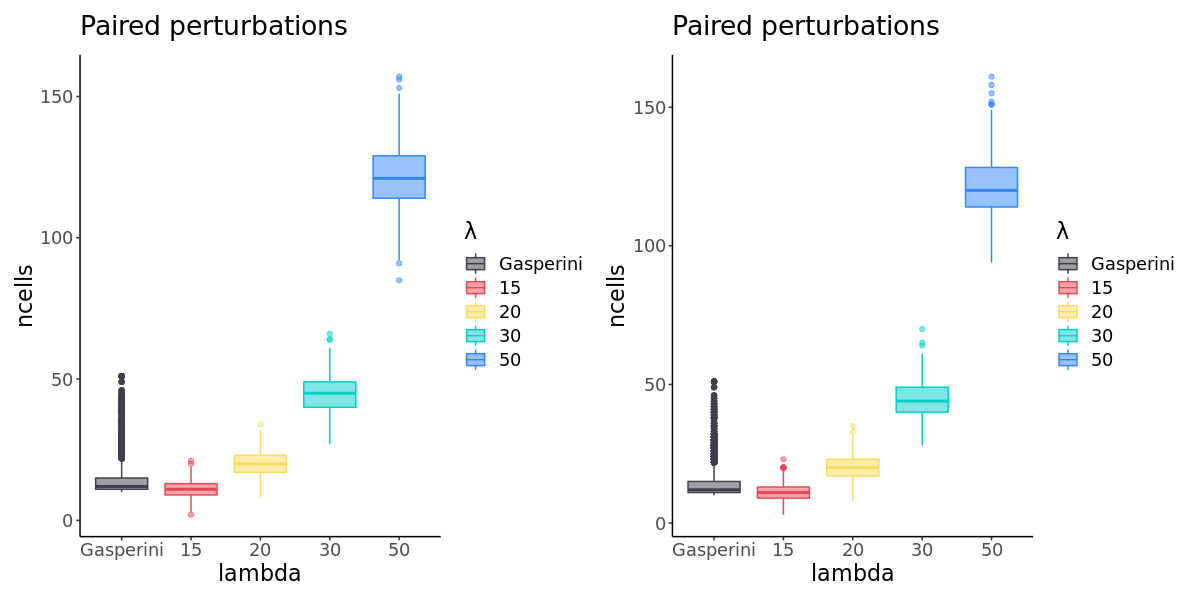

In [30]:
options(repr.plot.width = 12, repr.plot.height = 6)
(pos.ts.pair.freq.box + neg.ts.pair.freq.box) 

## Calculate number of cases that pass >10cell filter in simulated ata 

In [31]:
pos.n.passed <- c()

for (i in 1:length(pos.lambdas)) {
    cat(sprintf("lambda = %d\n", pos.lambdas[i]))
    n.passed <- sum(pos.ncells.per.pair[,i]>=10)
    print(n.passed)
    pos.n.passed[i] <- n.passed
}

neg.n.passed <- c()

for (i in 1:length(neg.lambdas)) {
    cat(sprintf("lambda = %d\n", neg.lambdas[i]))
    n.passed <- sum(neg.ncells.per.pair[,i]>=10)
    print(n.passed)
    neg.n.passed[i] <- n.passed
}

lambda = 15
[1] 339
lambda = 20
[1] 498
lambda = 30
[1] 500
lambda = 50
[1] 500
lambda = 15
[1] 325
lambda = 20
[1] 498
lambda = 30
[1] 500
lambda = 50
[1] 500


In [32]:
n.passed.df <- data.frame(pos=pos.n.passed, neg=neg.n.passed)
n.passed.df$lambda <- pos.lambdas
n.passed.df %>% relocate(lambda, .before=pos)


lambda,pos,neg
<dbl>,<int>,<int>
15,339,325
20,498,498
30,500,500
50,500,500


## Calculate nguides per cell
Here, we are calculating the number of gRNAs present in each cell

In [33]:
pos.nguides.per.cell.list <- list()
i <- 1

for (l in pos.lambdas) {
    print(l)
    onehot <- h5read(pos.h5.path, paste0('guides/one_hot/', l))
    pos.nguides.per.cell.list[[i]] <- rowSums(onehot)
    i <- i + 1
}

neg.nguides.per.cell.list <- list()
i <- 1

for (l in neg.lambdas) {
    print(l)
    onehot <- h5read(neg.h5.path, paste0('guides/one_hot/', l))
    neg.nguides.per.cell.list[[i]] <- rowSums(onehot)
    i <- i + 1
}

[1] 15
[1] 20
[1] 30
[1] 50
[1] 15
[1] 20
[1] 30
[1] 50


# Get number of unique gRNAs per cell in Gasperini data

In [34]:
h5.name <- '/iblm/netapp/home/karthik/GLiMMIRS/data/gasperini/processed/gasperini_data.h5'

library(rhdf5)
covariates <- h5read(
    h5.name,
    'expr/cell_covariates'
) 

In [35]:
gasperini.guides.per.cell <- covariates$guide_count

# Parse data for plotting # of gRNAs per cell

In [36]:
### parse table - pos
names(pos.nguides.per.cell.list) <- pos.lambdas
pos.nguides.per.cell.df <- data.frame(pos.nguides.per.cell.list)
colnames(pos.nguides.per.cell.df) <- pos.lambdas
pos.nguides.per.cell.df$cell <- 1:50000

pos.guides.per.cell.plotdf <- pos.nguides.per.cell.df %>% 
                            tidyr::pivot_longer(-cell, names_to = "lambda", values_to = "nguides")
pos.guides.per.cell.plotdf$lambda <- factor(pos.guides.per.cell.plotdf$lambda, levels = sort(pos.lambdas))

### parse table - neg
names(neg.nguides.per.cell.list) <- neg.lambdas
neg.nguides.per.cell.df <- data.frame(neg.nguides.per.cell.list)
colnames(neg.nguides.per.cell.df) <- neg.lambdas
neg.nguides.per.cell.df$cell <- 1:50000

neg.guides.per.cell.plotdf <- neg.nguides.per.cell.df %>% 
                            tidyr::pivot_longer(-cell, names_to = "lambda", values_to = "nguides")
neg.guides.per.cell.plotdf$lambda <- factor(neg.guides.per.cell.plotdf$lambda, levels = sort(neg.lambdas))

In [37]:
# add gasperini data
gasperini.guides.per.cell.df <- data.frame(cell=1:length(gasperini.guides.per.cell),
                                            lambda='Gasperini',
                                            nguides=gasperini.guides.per.cell)

pos.guides.per.cell.plotdf <- rbind(pos.guides.per.cell.plotdf, gasperini.guides.per.cell.df)
neg.guides.per.cell.plotdf <- rbind(neg.guides.per.cell.plotdf, gasperini.guides.per.cell.df)

### Plot

In [38]:
pos.guides.per.cell.hist <- ggplot(pos.guides.per.cell.plotdf, aes(x = nguides, color = lambda, fill = lambda)) + 
                            geom_histogram(alpha = 0.5, position = "identity", aes(y = ..density..)) + 
                            theme_classic() +
                            theme(text = element_text(size = 16)) +
                            guides(color=guide_legend(title=expression(lambda)),
                          fill = guide_legend(title=expression(lambda))) +
                            ggtitle("gRNAs per cell") + scale_fill_manual(values=group.colors) + scale_color_manual(values=group.colors)

neg.guides.per.cell.hist <- ggplot(neg.guides.per.cell.plotdf, aes(x = nguides, color = lambda, fill = lambda)) + 
                            geom_histogram(alpha = 0.5, position = "identity", aes(y = ..density..)) + 
                            theme_classic() +
                            theme(text = element_text(size = 16)) +
                            guides(color=guide_legend(title=expression(lambda)),
                          fill = guide_legend(title=expression(lambda))) +
                            ggtitle("gRNAs per cell") + scale_fill_manual(values=group.colors) + scale_color_manual(values=group.colors)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 1527 rows containing non-finite values (stat_bin).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 1527 rows containing non-finite values (stat_bin).”


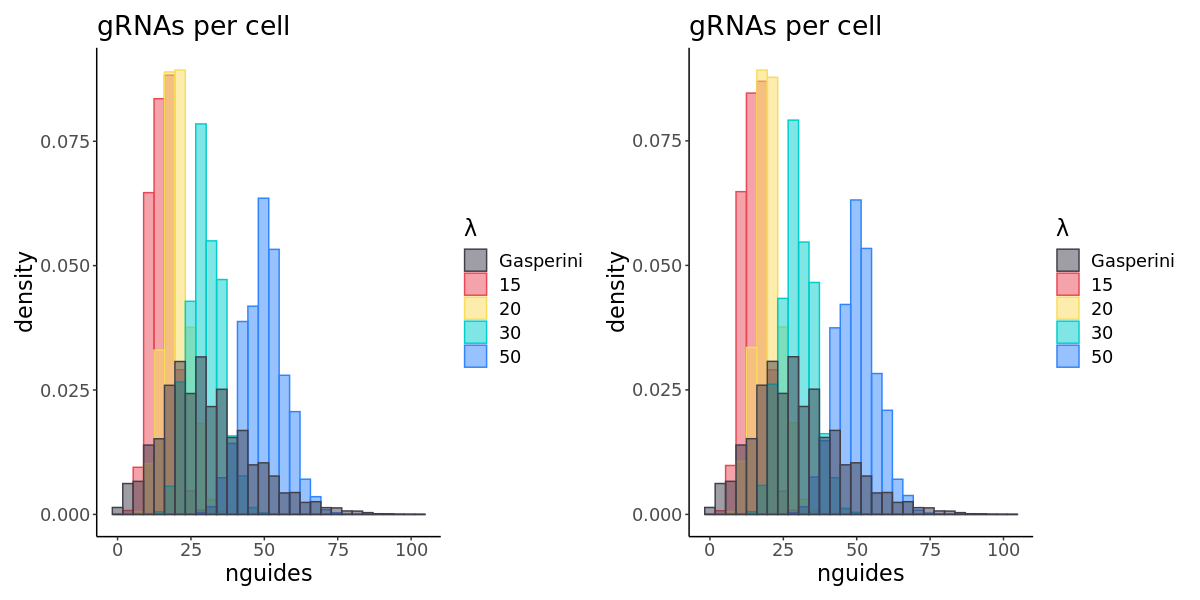

In [39]:
pos.guides.per.cell.hist + neg.guides.per.cell.hist

# Plot power curves 

In [40]:
pos.fpr.fh <- list.files("/iblm/netapp/data1/jezhou/crisprQTL/power_analysis_28-11-2023_filt10",
                    pattern = "plotdf_filt10.csv", full.names = TRUE)
pos.tnr.fh <- list.files("/iblm/netapp/data1/jezhou/crisprQTL/power_analysis_28-11-2023_filt10",
                     pattern = "NEG_filt10.csv", full.names = TRUE)

neg.fpr.fh <- list.files("/iblm/netapp/data1/jezhou/crisprQTL/power_analysis_NEG_EFFECTS_28-11-2023_filt10",
                    pattern = "plotdf_filt10.csv", full.names = TRUE)
neg.tnr.fh <- list.files("/iblm/netapp/data1/jezhou/crisprQTL/power_analysis_NEG_EFFECTS_28-11-2023_filt10",
                     pattern = "NEG_filt10.csv", full.names = TRUE)

In [41]:
# load files and combine

pos.fpr.dfs <- list()

for (i in 1:length(pos.fpr.fh)) {
    df <- read.csv(pos.fpr.fh[i])
    df$pair <- "interaction"
    df$interaction <- "positive"
    pos.fpr.dfs[[i]] <- df
    
}

pos.tnr.dfs <- list()

for (i in 1:length(pos.tnr.fh)) {
    df <- read.csv(pos.tnr.fh[i])
    df$pair <- "independent"
    df$interaction <- "positive"
    pos.tnr.dfs[[i]] <- df
}

neg.fpr.dfs <- list()

for (i in 1:length(neg.fpr.fh)) {
    df <- read.csv(neg.fpr.fh[i])
    df$pair <- "interaction"
    df$interaction <- "negative"
    neg.fpr.dfs[[i]] <- df
    
}

neg.tnr.dfs <- list()

for (i in 1:length(neg.tnr.fh)) {
    df <- read.csv(neg.tnr.fh[i])
    df$pair <- "independent"
    df$interaction <- "negative"
    neg.tnr.dfs[[i]] <- df
}

all.tpr <- rbind(do.call(rbind, pos.fpr.dfs), do.call(rbind, neg.fpr.dfs))
all.tnr <- rbind(do.call(rbind, pos.tnr.dfs), do.call(rbind, neg.tnr.dfs))


In [42]:
# rename columns
all.tpr.plotdf <- all.tpr %>% rename("TPR" = "pct.detected")
all.tnr.plotdf <- all.tnr %>% rename("TNR" = "pct.detected")
all.tnr.plotdf$FPR <- 1-all.tnr.plotdf$TNR

In [43]:
# map values to plot expressions
interaction_mapping <- list(
  'positive'=expression(paste(beta['AB']>0)),
  'negative'=expression(paste(beta['AB']<0))
)

interaction_labeller <- function(variable,value){
  return(interaction_mapping[value])
}


In [45]:
# Make a modified copy of the original data with expressions
tpr.plotdf.mod <- all.tpr.plotdf %>%
            mutate(across(interaction, factor, levels=c("negative","positive"))) %>%
              mutate(interaction = recode(interaction,
              "negative" = "{beta}[AB]<0",
              "positive" = "{beta}[AB]>0"  
              ))

tnr.plotdf.mod <- all.tnr.plotdf %>%
            mutate(across(interaction, factor, levels=c("negative","positive"))) %>%
              mutate(interaction = recode(interaction,
                "negative" = "{beta}[AB]<0",
                "positive" = "{beta}[AB]>0"
              ))


Plot

In [46]:
power.curves <- ggplot(tpr.plotdf.mod %>% filter(lambda !=75) %>% filter(abs(effect.size)<=3), aes(x = effect.size, y = TPR, color = as.factor(lambda))) +
                        geom_point(size = 2) + geom_line() +  theme_classic() + 
                    ylim(0,1) + xlim(-3.1, 3.1) +
                    guides(color=guide_legend(title=expression(lambda))) + 
                    ylab('Power')+
                    theme(text = element_text(size = 20),
                 plot.title = element_text(size = 14),
                 strip.text = element_text(size = 24),
                 legend.title = element_text(size = 20),
                 legend.position = "right") + 
                        facet_grid(cols=vars(interaction), scales = "free_x", labeller = label_parsed) +
                         scale_color_manual(values=group.colors.no.gasperini) + 
                         scale_x_continuous(breaks=unique(all.tpr.plotdf %>% pull(effect.size))) +
                         xlab(expression(beta[AB]))

fpr.curves <- ggplot(tnr.plotdf.mod %>% filter(lambda !=75), aes(x = effect.size, y = FPR, color = as.factor(lambda))) +
                        geom_point(size= 2) + geom_line() + theme_classic() + 
                    ylim(0.00,0.05)+
                    guides(color=guide_legend(title=expression(lambda))) + 
                    theme(text = element_text(size = 18),
                 plot.title = element_text(size = 14),
                 strip.text = element_text(size = 20),
                 legend.title = element_text(size = 20)) + 
                    facet_grid(cols=vars(interaction), scales = "free_x", labeller = label_parsed) +
                    scale_color_manual(values=group.colors.no.gasperini) +
                    scale_x_continuous(breaks=unique(all.tnr.plotdf %>% pull(effect.size))) +
                    xlab(expression(beta[AB]))


Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



Warning message:
“Removed 14 rows containing missing values (geom_point).”
Warning message:
“Removed 14 row(s) containing missing values (geom_path).”


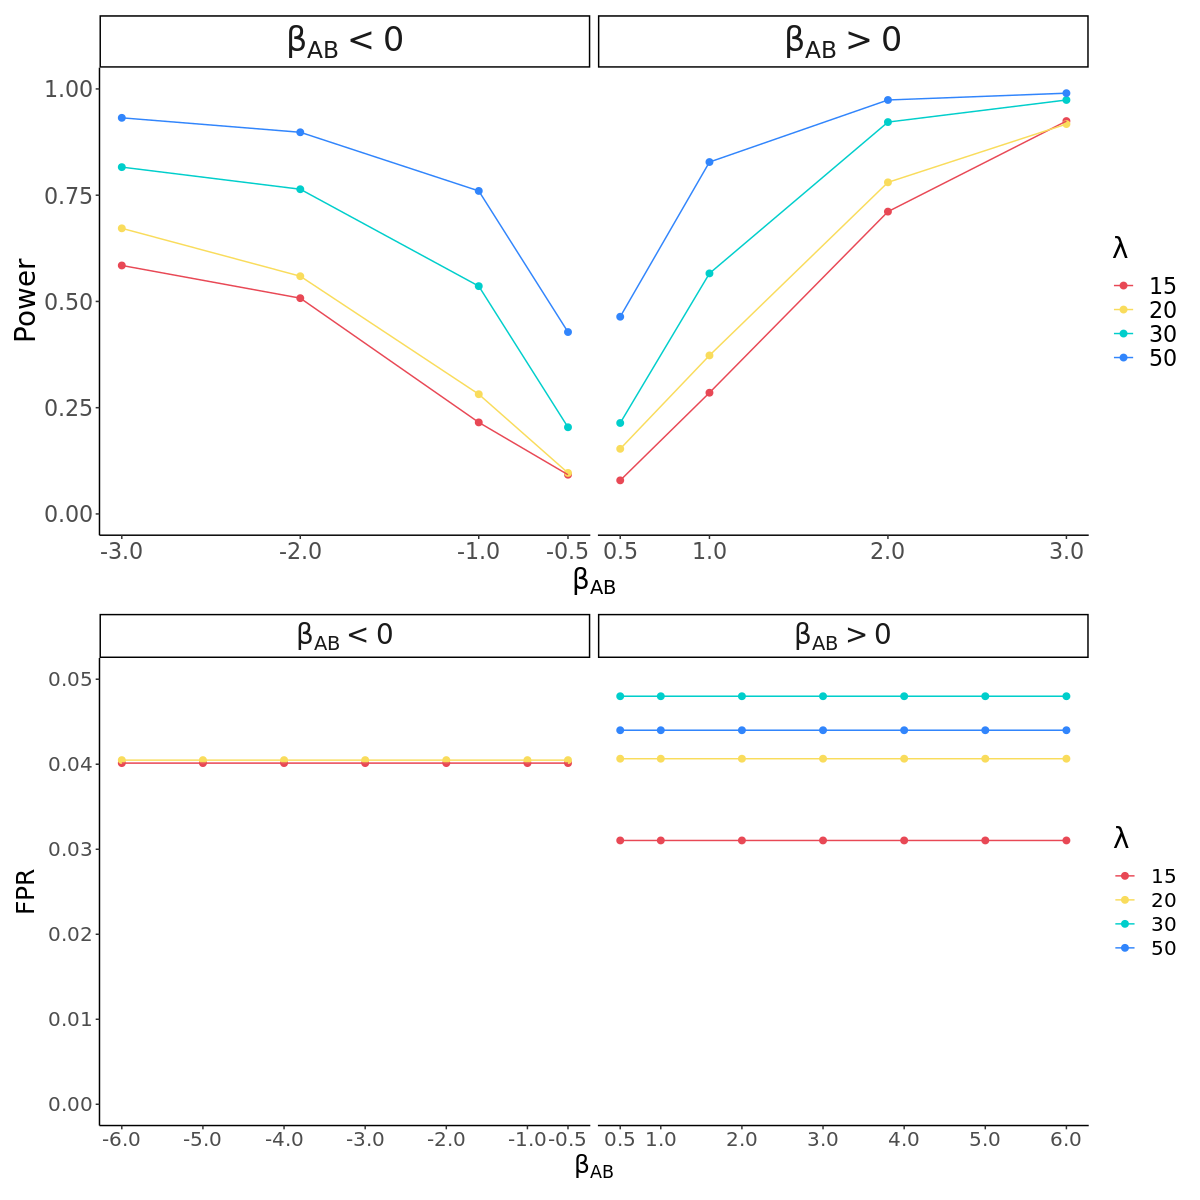

In [49]:
options(repr.plot.width = 12, repr.plot.height = 12)
power.curves / fpr.curves